In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import json
import re
import string
from IPython.display import display, HTML

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

In [2]:
VOCAB_SIZE = 10000
MAX_LEN = 80
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 2
FEED_FORWARD_DIM = 256
VALIDATION_SPLIT = 0.2
SEED = 42
LOAD_MODEL = False
BATCH_SIZE = 32
EPOCHS = 5

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jayshah1234","key":"b5a70f58d9814ed536fb83b549b26d2c"}'}

In [4]:
# Move the uploaded kaggle.json file to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d zynicide/wine-reviews

 94% 48.0M/50.9M [00:03<00:00, 21.9MB/s]
100% 50.9M/50.9M [00:03<00:00, 14.7MB/s]


In [6]:
# Now you can use the Kaggle API to download the dataset
kaggle_username = "zynicide"
dataset_name = " wine-reviews"

# Create the Kaggle dataset URL
dataset_url = f"{kaggle_username}/{dataset_name}"

# Unzip the downloaded dataset
!unzip -q {dataset_name}.zip -d {dataset_name}

In [7]:
# Load the full dataset
with open("/content/wine-reviews/winemag-data-130k-v2.json") as json_data:
    wine_data = json.load(json_data)

In [8]:
wine_data[10]

{'points': '87',
 'title': 'Kirkland Signature 2011 Mountain Cuvée Cabernet Sauvignon (Napa Valley)',
 'description': 'Soft, supple plum envelopes an oaky structure in this Cabernet, supported by 15% Merlot. Coffee and chocolate complete the picture, finishing strong at the end, resulting in a value-priced wine of attractive flavor and immediate accessibility.',
 'taster_name': 'Virginie Boone',
 'taster_twitter_handle': '@vboone',
 'price': 19,
 'designation': 'Mountain Cuvée',
 'variety': 'Cabernet Sauvignon',
 'region_1': 'Napa Valley',
 'region_2': 'Napa',
 'province': 'California',
 'country': 'US',
 'winery': 'Kirkland Signature'}

1. Load the data and create a list of text string descriptions of each wine.


2. Pad punctuation with spaces, so that each punctuation mark is treated as a separate word.


3. Pass the strings through a TextVectorization layer that tokenizes the data and
pads/clips each string to a fixed length.


4. Create a training set where the inputs are the tokenized text strings and the outputs to predict are the same strings shifted by one token.


In [9]:
# Filter the dataset
filtered_data = [
    "wine review : "
    + x["country"]
    + " : "
    + x["province"]
    + " : "
    + x["variety"]
    + " : "
    + x["description"]
    for x in wine_data
    if x["country"] is not None
    and x["province"] is not None
    and x["variety"] is not None
    and x["description"] is not None
]

In [10]:
# Count the recipes
n_wines = len(filtered_data)
print(f"{n_wines} recipes loaded")

129907 recipes loaded


In [11]:
example = filtered_data[25]
print(example)

wine review : US : California : Pinot Noir : Oak and earth intermingle around robust aromas of wet forest floor in this vineyard-designated Pinot that hails from a high-elevation site. Small in production, it offers intense, full-bodied raspberry and blackberry steeped in smoky spice and smooth texture.


In [12]:
# Pad the punctuation, to treat them as separate 'words'
def pad_punctuation(s):
    s = re.sub(f"([{string.punctuation}, '\n'])", r" \1 ", s)
    s = re.sub(" +", " ", s)
    return s


text_data = [pad_punctuation(x) for x in filtered_data]

In [13]:
# Display an example of a recipe
example_data = text_data[25]
example_data

'wine review : US : California : Pinot Noir : Oak and earth intermingle around robust aromas of wet forest floor in this vineyard - designated Pinot that hails from a high - elevation site . Small in production , it offers intense , full - bodied raspberry and blackberry steeped in smoky spice and smooth texture . '

In [14]:
# Convert to a Tensorflow Dataset
text_ds = (
    tf.data.Dataset.from_tensor_slices(text_data)
    .batch(BATCH_SIZE)
    .shuffle(1000)
)

In [15]:
# Create a vectorisation layer
vectorize_layer = layers.TextVectorization(
    standardize="lower",
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN + 1,
)

In [16]:
# Adapt the layer to the training set
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()

In [17]:
# Display some token:word mappings
for i, word in enumerate(vocab[:10]):
    print(f"{i}: {word}")

0: 
1: [UNK]
2: :
3: ,
4: .
5: and
6: the
7: wine
8: a
9: of


In [18]:
# Display the same example converted to ints
example_tokenised = vectorize_layer(example_data)
print(example_tokenised.numpy())

[   7   10    2   20    2   29    2   43   62    2   55    5  243 4145
  453  634   26    9  497  499  667   17   12  142   14 2214   43   25
 2484   32    8  223   14 2213  948    4  594   17  987    3   15   75
  237    3   64   14   82   97    5   74 2633   17  198   49    5  125
   77    4    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


In [19]:
# Create the training set of recipes and the same text shifted by one word
def prepare_inputs(text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


train_ds = text_ds.map(prepare_inputs)

In [20]:
example_input_output = train_ds.take(1).get_single_element()

In [21]:
# Example Input
example_input_output[0][0]

<tf.Tensor: shape=(80,), dtype=int64, numpy=
array([   7,   10,    2,   42,    2,  432,   98,    2,  729,  101,   14,
         61,    2,  161,    9,    6,  248,  289,  320,  515,   17, 7382,
          3,   12,   13,  299,    3, 1368,    5,   73,    3,   64,    9,
        347,   22,    5, 1921,   16,    4,  508,    9,  126,   32,    6,
        373, 1145,   17,  244,  156,  268,    5,   49,   19,    6,  361,
          4,    8,  690,    3,  284,  311,   83,    6,    7,   18,   21,
       2355,    4,   35,   66,    4,    0,    0,    0,    0,    0,    0,
          0,    0,    0])>

In [22]:
# Example Output (shifted by one token)
example_input_output[1][0]

<tf.Tensor: shape=(80,), dtype=int64, numpy=
array([  10,    2,   42,    2,  432,   98,    2,  729,  101,   14,   61,
          2,  161,    9,    6,  248,  289,  320,  515,   17, 7382,    3,
         12,   13,  299,    3, 1368,    5,   73,    3,   64,    9,  347,
         22,    5, 1921,   16,    4,  508,    9,  126,   32,    6,  373,
       1145,   17,  244,  156,  268,    5,   49,   19,    6,  361,    4,
          8,  690,    3,  284,  311,   83,    6,    7,   18,   21, 2355,
          4,   35,   66,    4,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])>

! In Keras, we can build a Multi
HeadAttention layer that concatenates the output from multiple attention heads,
allowing each to learn a distinct attention mechanism so that the layer as a whole can
learn more complex relationships.

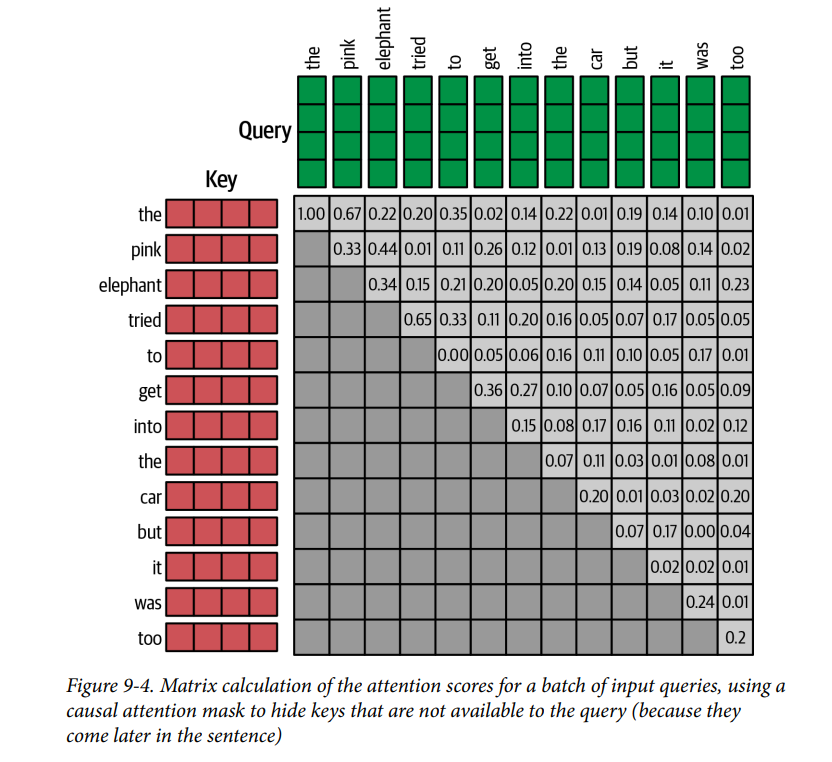

In [23]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

Causal masking is only required in decoder Transformers such as
GPT, where the task is to sequentially generate tokens given previous tokens. Masking out future tokens during training is therefore
essential.


Other flavors of Transformer (e.g., encoder Transformers) do not
need causal masking, because they are not trained to predict the
next token. For example Google’s BERT predicts masked words
within a given sentence, so it can use context from both before and
after the word in question.


We will explore the different types of Transformers in more detail
at the end of the chapter

A Transformer block is a single component within a Transformer that applies some
skip connections, feed-forward (dense) layers, and normalization around the multi‐
head attention layer.

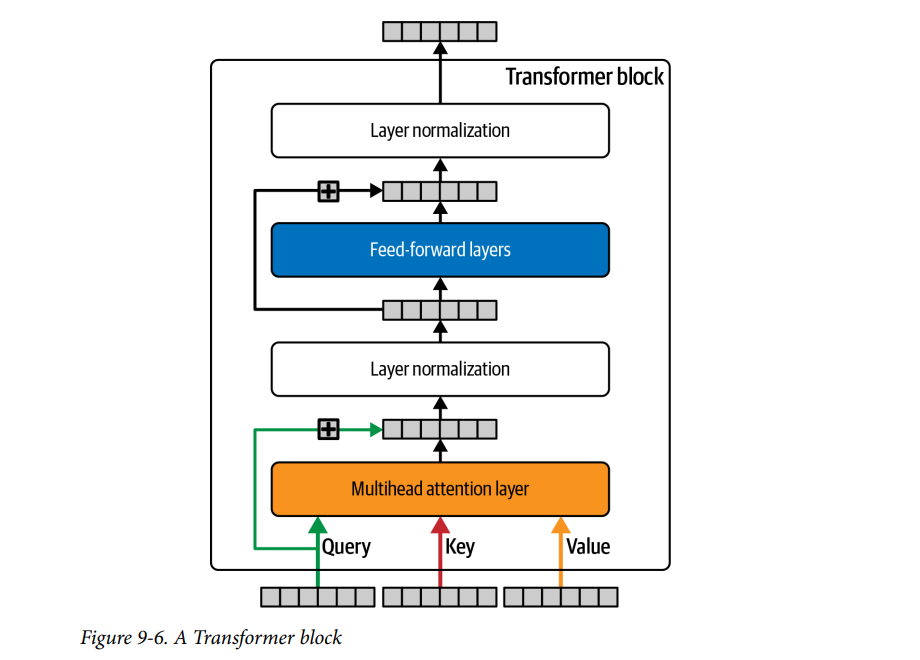

Layer normalization is used in the Transformer block to provide stability to
the training process. We have already seen the batch normalization layer in action
throughout this book, where the output from each channel is normalized to have a mean of 0 and standard deviation of 1. The normalization statistics are calculated
across the batch and spatial dimensions.


In contrast, layer normalization in a Transformer block normalizes each position of
each sequence in the batch by calculating the normalizing statistics across the chan‐
nels. It is the complete opposite of batch normalization, in terms of how the normal‐
ization statistics are calculated

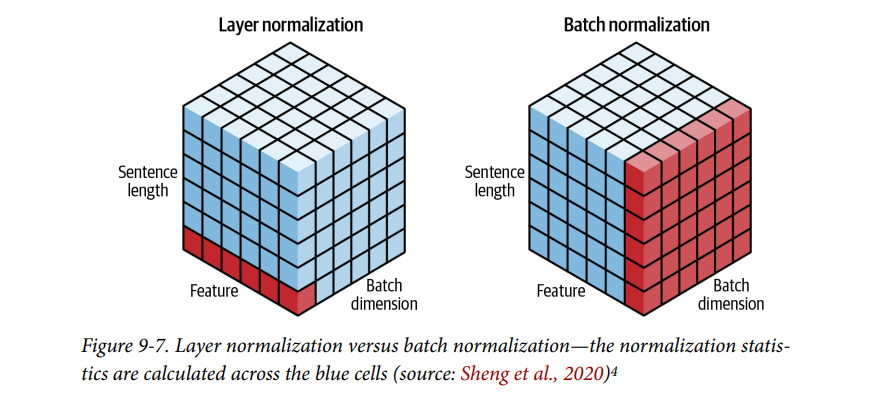

In [24]:
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, key_dim, embed_dim, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config


The token embedding is created using a standard Embedding layer to convert each
token into a learned vector. We can create the positional embedding in the same way,
using a standard Embedding layer to convert each integer position into a learned
vector.

To construct the joint token–position encoding, the token embedding is added to the
positional embedding. This way, the meaning and position of
each word in the sequence are captured in a single vector.


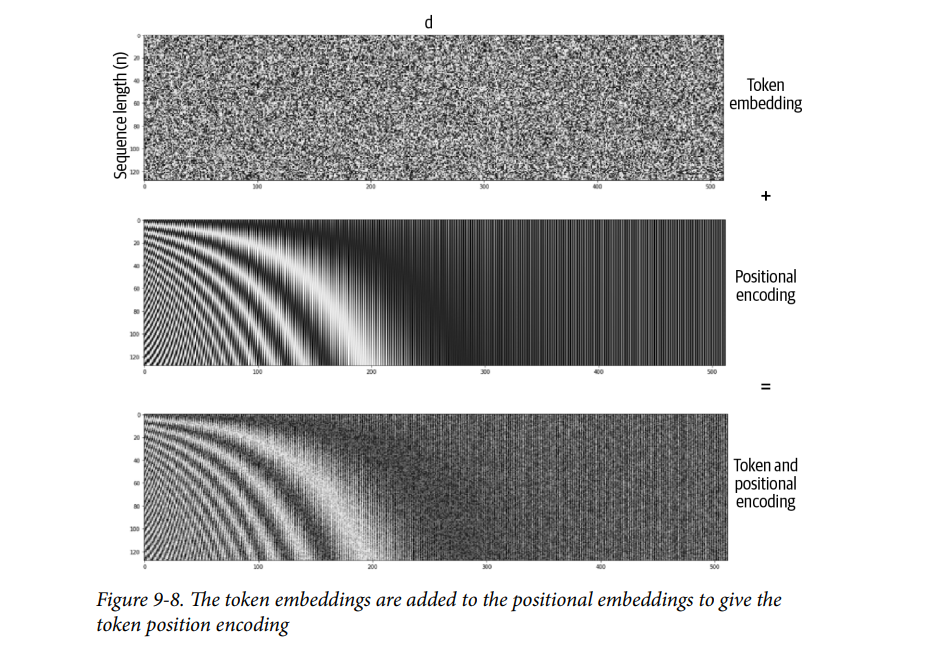

In [25]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = layers.Embedding(input_dim=max_len, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_len": self.max_len,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

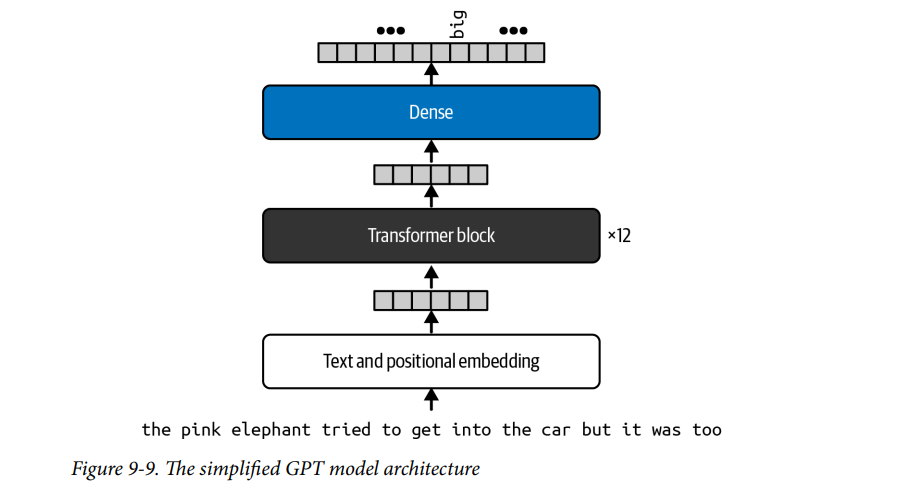

In [26]:
inputs = layers.Input(shape=(None,), dtype=tf.int32)
x = TokenAndPositionEmbedding(MAX_LEN, VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM
)(x)
outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
gpt = models.Model(inputs=inputs, outputs=[outputs, attention_scores])
gpt.compile("adam", loss=[losses.SparseCategoricalCrossentropy(), None])

In [27]:
gpt.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 token_and_position_embeddi  (None, None, 256)         2580480   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block (Transfo  ((None, None, 256),       658688    
 rmerBlock)                   (None, 2, None, None))             
                                                                 
 dense_2 (Dense)             (None, None, 10000)       2570000   
                                                                 
Total params: 5809168 (22.16 MB)
Trainable params: 5809168 (22.16 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [28]:
# Create a TextGenerator checkpoint
class TextGenerator(callbacks.Callback):
    def __init__(self, index_to_word, top_k=10):
        self.index_to_word = index_to_word
        self.word_to_index = {
            word: index for index, word in enumerate(index_to_word)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def generate(self, start_prompt, max_tokens, temperature):
        start_tokens = [
            self.word_to_index.get(x, 1) for x in start_prompt.split()
        ]
        sample_token = None
        info = []
        while len(start_tokens) < max_tokens and sample_token != 0:
            x = np.array([start_tokens])
            y, att = self.model.predict(x, verbose=0)
            sample_token, probs = self.sample_from(y[0][-1], temperature)
            info.append(
                {
                    "prompt": start_prompt,
                    "word_probs": probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_tokens.append(sample_token)
            start_prompt = start_prompt + " " + self.index_to_word[sample_token]
        print(f"\ngenerated text:\n{start_prompt}\n")
        return info

    def on_epoch_end(self, epoch, logs=None):
        self.generate("wine review", max_tokens=80, temperature=1.0)

In [29]:
# Tokenize starting prompt
text_generator = TextGenerator(vocab)

In [30]:
gpt.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[text_generator],
)

Epoch 1/5
4059/4060 [============================>.] - ETA: 0s - loss: 2.2510 - dense_2_loss: 2.2510
generated text:
wine review : france : bordeaux : bordeaux - style red blend : the shining in the blend of merlot this finely structured wine , balances the dry tannins with rich fruit and a balanced green character . this will allow it to age . a few acres of two years to unwind and integrate , drink from 2019 . 

4060/4060 [==============================] - 165s 39ms/step - loss: 2.2509 - dense_2_loss: 2.2509
Epoch 2/5
4059/4060 [============================>.] - ETA: 0s - loss: 1.9590 - dense_2_loss: 1.9590
generated text:
wine review : germany : rheingau : riesling : buoyantly perfumed tones of sweet sugar and dried apricots and herbs on the palate yet never quite balancing . the acidity extends for . it ' s complex and nuanced with nuanced layers of dusty , mineral , crushed minerals and crushed mineral notes . sunny tangerine and tangerine finish strikes you exceptionally clean , 

Generating text


We can generate new text by applying the following process:
1. Feed the network with an existing sequence of words and ask it to predict the following word.
2. Append this word to the existing sequence and repeat.


In [31]:
def print_probs(info, vocab, top_k=5):
    for i in info:
        highlighted_text = []
        for word, att_score in zip(
            i["prompt"].split(), np.mean(i["atts"], axis=0)
        ):
            highlighted_text.append(
                '<span style="background-color:rgba(135,206,250,'
                + str(att_score / max(np.mean(i["atts"], axis=0)))
                + ');">'
                + word
                + "</span>"
            )
        highlighted_text = " ".join(highlighted_text)
        display(HTML(highlighted_text))

        word_probs = i["word_probs"]
        p_sorted = np.sort(word_probs)[::-1][:top_k]
        i_sorted = np.argsort(word_probs)[::-1][:top_k]
        for p, i in zip(p_sorted, i_sorted):
            print(f"{vocab[i]}:   \t{np.round(100*p,2)}%")
        print("--------\n")

In [32]:
info = text_generator.generate(
    "wine review : us", max_tokens=80, temperature=1.0
)


generated text:
wine review : us : washington : sangiovese : blackberry , ripe and dark , brawny soil , some champoux , ciel du cheval , weinbau , obelisco and conner lee vineyards across the columbia valley . lighter , forward and smooth , neatly balanced , a brisk - style but dry wine with excellent penetration , intensity and penetration is balance . all five way through its own . 



In [33]:
info = text_generator.generate(
    "wine review : italy", max_tokens=80, temperature=0.5
)


generated text:
wine review : italy : tuscany : sangiovese : here ' s a simple but fresh rosso shows pretty cherry notes of spice and forest berry . the wine is medium bodied and offers good intensity and a long , spicy finish . 



In [34]:
info = text_generator.generate(
    "wine review : germany", max_tokens=80, temperature=0.5
)
print_probs(info, vocab)


generated text:
wine review : germany : mosel : riesling : this riesling is a bit rustic , with hints of petrol and petrol that lend a savory tone to the palate . it ' s intensely sweet and ripe , with honeydew melon and peach flavors . drink now and over the next few years . 



::   	100.0%
-:   	0.0%
zealand:   	0.0%
grosso:   	0.0%
blanc:   	0.0%
--------



mosel:   	99.02%
rheingau:   	0.73%
pfalz:   	0.12%
rheinhessen:   	0.09%
nahe:   	0.02%
--------



::   	99.55%
-:   	0.45%
grosso:   	0.0%
blanc:   	0.0%
blanca:   	0.0%
--------



riesling:   	99.98%
pinot:   	0.02%
spätburgunder:   	0.0%
gewürztraminer:   	0.0%
grüner:   	0.0%
--------



::   	100.0%
grosso:   	0.0%
-:   	0.0%
blanc:   	0.0%
blend:   	0.0%
--------



this:   	34.43%
a:   	18.58%
whiffs:   	14.91%
while:   	8.64%
fresh:   	4.4%
--------



riesling:   	34.11%
off:   	33.19%
is:   	24.28%
wine:   	2.23%
intensely:   	1.26%
--------



is:   	89.1%
':   	4.55%
has:   	1.66%
builds:   	1.04%
offers:   	0.9%
--------



a:   	74.19%
intensely:   	11.37%
an:   	2.54%
unctuously:   	1.17%
surprisingly:   	0.72%
--------



bit:   	86.2%
[UNK]:   	1.38%
touch:   	1.3%
veritable:   	1.08%
standout:   	1.01%
--------



of:   	30.21%
closed:   	9.38%
rustic:   	7.74%
off:   	6.06%
one:   	5.47%
--------



,:   	70.99%
in:   	13.65%
on:   	8.06%
and:   	4.45%
with:   	1.31%
--------



but:   	77.7%
with:   	21.62%
yet:   	0.24%
showing:   	0.09%
boasting:   	0.08%
--------



hints:   	51.32%
a:   	26.77%
notes:   	4.7%
whiffs:   	4.47%
aromas:   	4.26%
--------



of:   	100.0%
to:   	0.0%
at:   	0.0%
,:   	0.0%
that:   	0.0%
--------



petrol:   	77.64%
sweet:   	2.94%
struck:   	2.87%
green:   	1.92%
wet:   	1.56%
--------



and:   	82.16%
,:   	13.91%
on:   	3.22%
.:   	0.34%
that:   	0.13%
--------



petrol:   	70.9%
slate:   	8.67%
earth:   	3.52%
smoke:   	2.12%
wet:   	1.63%
--------



on:   	54.31%
.:   	21.47%
,:   	11.46%
notes:   	7.57%
-:   	2.75%
--------



are:   	74.24%
lead:   	6.61%
lend:   	4.75%
add:   	4.01%
frame:   	2.66%
--------



a:   	57.27%
complexity:   	30.66%
an:   	5.95%
nuance:   	1.83%
vibrance:   	1.14%
--------



savory:   	68.08%
slightly:   	12.88%
sweet:   	2.78%
distinctly:   	2.0%
rustic:   	1.24%
--------



tone:   	78.64%
edge:   	18.04%
,:   	2.52%
element:   	0.36%
complexity:   	0.09%
--------



to:   	99.98%
.:   	0.02%
on:   	0.0%
and:   	0.0%
that:   	0.0%
--------



the:   	51.73%
its:   	9.88%
pressed:   	8.4%
fresh:   	8.33%
a:   	5.39%
--------



palate:   	45.63%
nose:   	40.22%
sweet:   	8.47%
ripe:   	0.87%
bright:   	0.73%
--------



.:   	77.43%
,:   	18.94%
that:   	1.46%
and:   	1.24%
of:   	0.77%
--------



it:   	87.15%
off:   	3.12%
dry:   	1.9%
while:   	1.03%
crisp:   	0.77%
--------



':   	99.97%
is:   	0.02%
finishes:   	0.0%
drinks:   	0.0%
has:   	0.0%
--------



s:   	100.0%
ll:   	0.0%
[UNK]:   	0.0%
d:   	0.0%
t:   	0.0%
--------



dry:   	22.04%
a:   	16.86%
off:   	16.79%
light:   	8.24%
intensely:   	7.37%
--------



concentrated:   	43.38%
fruity:   	21.42%
sweet:   	12.66%
ripe:   	9.01%
floral:   	2.68%
--------



,:   	51.24%
and:   	42.48%
with:   	4.33%
-:   	0.71%
in:   	0.4%
--------



tart:   	34.45%
honeyed:   	26.85%
fruity:   	5.64%
ripe:   	3.66%
sour:   	3.52%
--------



,:   	93.32%
with:   	6.3%
.:   	0.14%
on:   	0.09%
yet:   	0.05%
--------



with:   	59.55%
but:   	27.0%
yet:   	12.82%
almost:   	0.14%
offering:   	0.09%
--------



flavors:   	33.91%
a:   	29.89%
sweet:   	6.5%
yellow:   	5.6%
apple:   	4.25%
--------



melon:   	68.56%
and:   	20.25%
flavors:   	5.94%
,:   	4.74%
-:   	0.21%
--------



and:   	51.86%
,:   	47.61%
flavors:   	0.36%
fruit:   	0.06%
flavor:   	0.05%
--------



peach:   	53.02%
apple:   	17.9%
white:   	8.18%
lime:   	4.92%
pear:   	2.06%
--------



flavors:   	99.83%
fruit:   	0.08%
notes:   	0.05%
-:   	0.01%
,:   	0.01%
--------



.:   	69.76%
,:   	23.67%
that:   	4.98%
and:   	1.37%
leading:   	0.05%
--------



:   	52.71%
it:   	23.63%
drink:   	13.17%
finishes:   	6.9%
the:   	1.55%
--------



now:   	98.99%
it:   	0.62%
up:   	0.23%
this:   	0.07%
now–2016:   	0.03%
--------



.:   	79.67%
through:   	19.64%
with:   	0.25%
and:   	0.2%
,:   	0.1%
--------



over:   	95.7%
through:   	1.75%
should:   	1.45%
until:   	0.42%
hold:   	0.17%
--------



the:   	99.87%
a:   	0.11%
its:   	0.02%
5–10:   	0.0%
many:   	0.0%
--------



next:   	100.0%
medium:   	0.0%
palate:   	0.0%
dry:   	0.0%
long:   	0.0%
--------



few:   	72.28%
year:   	13.99%
four:   	4.55%
five:   	2.56%
2–3:   	1.3%
--------



years:   	98.98%
months:   	1.02%
swirls:   	0.0%
decades:   	0.0%
[UNK]:   	0.0%
--------



.:   	99.96%
,:   	0.02%
or:   	0.01%
to:   	0.01%
;:   	0.0%
--------



:   	100.0%
drink:   	0.0%
screwcap:   	0.0%
imported:   	0.0%
enjoy:   	0.0%
--------



It is incredibly informative to be able to interrogate the network in this way, to under‐
stand exactly where it is pulling information from in order to make accurate deci‐
sions about each subsequent word.